# Preparation

### Loading dependencies

In [1]:
# Libraries 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tf_utils
from time import time
from datetime import date
import pathlib
import albumentations as A

# Training

### Setting main parameters and seeds

In [6]:
# Parameters
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123
FPATH = 'D:/Master thesis/saved_models'

tf.random.set_seed(SEED)
np.random.seed(SEED)

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

### Loading datasets

In [ ]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
kaggle_ds = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = kaggle_ds.class_names
no_classes = len(class_names)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(kaggle_ds, train_part, valid_part, test_part, seed=SEED)
print(f'Batches ({BATCH_SIZE} images per batch) in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
kaggle_ds = kaggle_ds.map(tf_utils.normalize)
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize)
test_ds = test_ds.map(tf_utils.normalize)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Batches (32 images per batch) in subsets:
Train: 219
Validation: 47
Test: 48


### Importing the model

#### Inception

In [21]:
# Constructing a model
name = 'InceptionV3'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dropout(rate=0.4, seed=SEED))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

#### VGG

In [17]:
# Constructing a model
name = 'VGG19'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### ResNet

In [4]:
# Constructing a model
name = 'ResNet50'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### MobileNet

In [5]:
# Constructing a model
name = 'MobileNet'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Compiling the model and fitting

In [5]:
# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 75)                75075     
                                                                 
Total params: 25,711,787
Trainable params: 25,658,667
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

training_date = date.today()
model_dir_name = f'{model.name}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name)
model_dir_name += str(ctr)

print(model_dir_name)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model',
        monitor='val_accuracy',
        save_best_only=True
    )
]

t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds),
    callbacks=callbacks
)

training_time = time() - t0

ResNet50_(2023-04-13)_1
Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 1.8885 - accuracy: 0.5168

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


219/219 [==============================] - 547s 2s/step - loss: 1.8885 - accuracy: 0.5168 - val_loss: 5.7383 - val_accuracy: 0.0175
Epoch 2/100
217/219 [============================>.] - ETA: 3s - loss: 0.6529 - accuracy: 0.8026

KeyboardInterrupt: 

### Evaluation and saving

In [20]:
model = tf.keras.models.load_model(f'{FPATH}/{model_dir_name}/model')

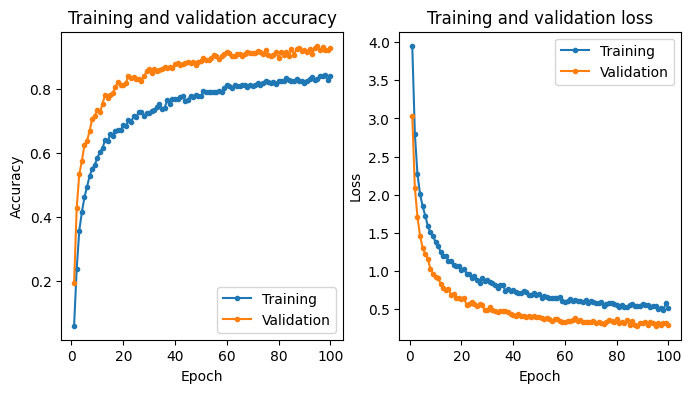

In [21]:
tf_utils.plot_history(history)

tf_utils.save_json(f'{FPATH}/{model_dir_name}/history.json', history.history)
#json.dump(history.history, open(f'{FPATH}/{model_dir_name}/history.json', 'w'))

In [22]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 80s 439ms/step - loss: 0.3065 - accuracy: 0.9199
Kaggle set evaluation: 
Test loss: 0.30653977394104004
Test accuracy: 0.919921875


1/1 [==============================] - 1s 1s/step


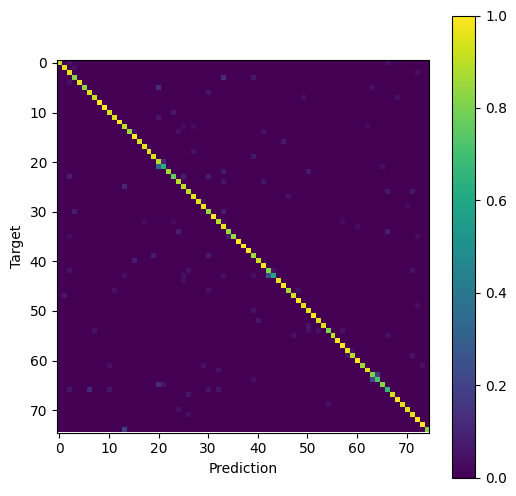

In [23]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m,figsize=(6,6))
plt.show()

In [24]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 8s 381ms/step - loss: 1.0195 - accuracy: 0.7029
Nature set evaluation: 
Test loss: 1.0194560289382935
Test accuracy: 0.7028985619544983


1/1 [==============================] - 4s 4s/step


d:\Master thesis\MasterThesis-1\tf_utils.py:182: RuntimeWarning: invalid value encountered in divide
  mat[i, :] /= normalization[i]


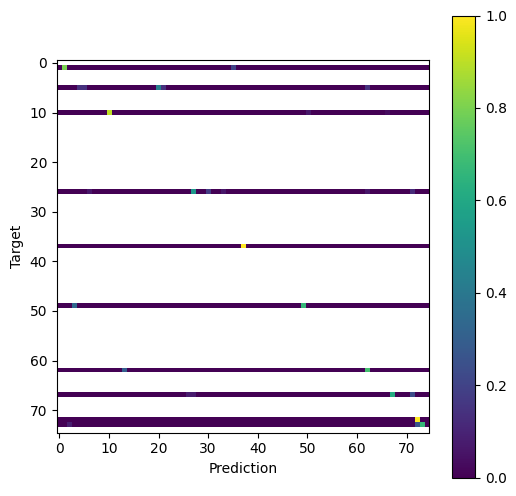

In [25]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m,figsize=(6,6))
plt.show()

In [26]:
# Evaluating inference time
t0 = time()
model.predict(kaggle_ds)
t1 = time()
inf_time = (t1 - t0) * 1000 / 10033

314/314 [==============================] - 142s 437ms/step


In [27]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'batch_size': BATCH_SIZE,
    'seed': SEED,
    'epochs': EPOCHS,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'inference_time': inf_time,
    'comment': '',
    'test_confusion': m.tolist(),
    'nature_confusion': nature_m.tolist()
    }

tf_utils.save_json(f'{FPATH}/{model_dir_name}/info.json', info)
#json.dump(info, open(f'{FPATH}/{model_dir_name}/info.json', 'w'))

# Influence of image quality

### Preparing functions required for transforming images

In [2]:
# Auxiliary functions
from tf_utils import transform_image, prepare_mapping, set_shapes

def test_transformed(model_paths, transforms, dataset, avg_amount=10):
    '''
    Performs series of tests of tensroflow models on given dataset transformed with some albumentations. For every model
    and every transformation results is averaged over `avg_amount` runs.

    Arguments:
        `model_paths`: list of paths to directories of models on which tests will be performed
        `transforms`: dictionary that should contain these three items:

            * list of albumentations to apply with key `list`\n
            * list of corresponding parameters controlling transformation with key `parameters`\n
            * name of transformation with key `name`
        `dataset`: tensorflow dataset of images on which models will be tested
        `avg_amount`: number of runs over which results will be averaged for every pair (model, transformation)

    Returns:
        `df`: pandas DataFrame with columns containing model's dictionary name, model's name, transformation parameter, loss and accuracy
    '''
    rows = []

    for path in model_paths:
        info = tf_utils.load_json(str(path) + '/info.json')
        np.random.seed(info['seed'])
        tf.random.set_seed(info['seed'])

        model = tf.keras.models.load_model(str(path) + '/model')
        print(f'Testing {path.name} in progress:')

        for itr, transform in enumerate(transforms['list']):
            print(f'\tTransform {itr+1}/{len(transforms["list"])}:')
            loss = 0
            accuracy = 0
            for itr2 in range(avg_amount):
                print(f'\t\t{itr2/avg_amount*100 : 3.0f}%', end='\r')

                tmp_ds = dataset.map(prepare_mapping(transform)).prefetch(tf.data.AUTOTUNE)
                tmp_ds = tmp_ds.map(set_shapes()).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

                tmp_loss, tmp_acc = model.evaluate(tmp_ds, verbose=False)
                loss += tmp_loss
                accuracy += tmp_acc

            print(f'\t\tLoss: {loss / avg_amount}, Accuracy: {accuracy / avg_amount}')
            rows.append({
                'saved_model': path.name,
                'model': model.name,
                'loss': loss / avg_amount,
                'accuracy': accuracy / avg_amount,
                transforms['name']: transforms['parameters'][itr]
            })
        
    df = pd.DataFrame(rows)
    return df

### Finding and choosing models

In [5]:
# Listing available models
FPATH = 'D:/Master thesis/saved_models'
AUG = 20

model_paths = list(pathlib.Path(FPATH).glob('*'))
for i, p in enumerate(model_paths):
    info = tf_utils.load_json(str(p) + '/info.json')
    print(i, p.name, info['test_accuracy'], info['nature_accuracy'])

selected = model_paths[6:9] + model_paths[25:28]
selected

0 InceptionV3_(2023-04-07)_0 0.974609375 0.8695652484893799
1 InceptionV3_(2023-04-08)_0 0.9791666865348816 0.8550724983215332
2 InceptionV3_(2023-04-08)_1 0.9798177480697632 0.8405797481536865
3 InceptionV3_aug100_(2023-05-10)_1 0.9594953656196594 0.7753623127937317
4 InceptionV3_aug100_(2023-05-13)_0 0.9641434550285339 0.8115942478179932
5 InceptionV3_aug100_(2023-05-14)_0 0.9628154039382935 0.8405797481536865
6 InceptionV3_aug20_(2023-05-11)_0 0.9661355018615723 0.8695652484893799
7 InceptionV3_aug20_(2023-05-12)_0 0.9687915444374084 0.8333333730697632
8 InceptionV3_aug20_(2023-05-15)_0 0.9694555401802063 0.8333333730697632
9 InceptionV3_aug40_(2023-05-11)_2 0.9774236679077148 0.8695652484893799
10 InceptionV3_aug40_(2023-05-12)_0 0.967463493347168 0.8405797481536865
11 InceptionV3_aug40_(2023-05-15)_0 0.9707835912704468 0.8985507488250732
12 InceptionV3_aug60_(2023-05-11)_0 0.9741036295890808 0.8695652484893799
13 InceptionV3_aug60_(2023-05-13)_0 0.9628154039382935 0.81159424781799

[WindowsPath('D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-12)_0'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-15)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_aug20_(2023-05-15)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_aug20_(2023-05-18)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_aug20_(2023-05-19)_0')]

### Loading the testing dataset

In [10]:
# Loading the dataset
ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=None
)

ds = ds.map(tf_utils.normalize).prefetch(tf.data.AUTOTUNE)

Found 138 files belonging to 75 classes.


### Running tests

#### Brightness

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 70.5132908821106, Accuracy: 1.7391304671764374
	Transform 2/19:
		Loss: 28.653287649154663, Accuracy: 5.579710006713867
	Transform 3/19:
		Loss: 15.92212700843811, Accuracy: 6.9565218687057495
	Transform 4/19:
		Loss: 11.485658288002014, Accuracy: 7.536231875419617
	Transform 5/19:
		Loss: 8.49070531129837, Accuracy: 8.115941882133484
	Transform 6/19:
		Loss: 7.312748730182648, Accuracy: 8.333333134651184
	Transform 7/19:
		Loss: 6.754623055458069, Accuracy: 8.47826063632965
	Transform 8/19:
		Loss: 6.332069098949432, Accuracy: 8.695651888847351
	Transform 9/19:
		Loss: 6.0786784291267395, Accuracy: 8.623188138008118
	Transform 10/19:
		Loss: 5.897654473781586, Accuracy: 8.695651888847351
	Transform 11/19:
		Loss: 5.995318353176117, Accuracy: 8.623188138008118
	Transform 12/19:
		Loss: 6.269143223762512, Accuracy: 8.623188138008118
	Transform 13/19:
		Loss: 7.017915487289429, Accuracy: 8.405796885490417
	Transform

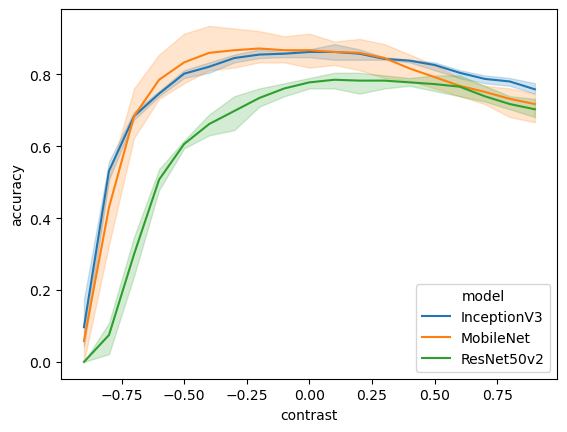

In [40]:
params = np.arange(-0.9, 1, 0.1)
transforms_list = [A.RandomBrightnessContrast(brightness_limit=(i,i), contrast_limit=(0,0), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'brightness'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()
df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")


#### Contrast

In [ ]:
params = np.arange(-0.9, 1, 0.1)
transforms_list = [A.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(i,i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'contrast'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()
df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

#### Gaussian noise

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.6031642019748688, Accuracy: 0.8768115997314453
	Transform 2/19:
		Loss: 0.6108841478824616, Accuracy: 0.8840579926967621
	Transform 3/19:
		Loss: 0.6407016694545746, Accuracy: 0.8731883943080903
	Transform 4/19:
		Loss: 0.6664171338081359, Accuracy: 0.8630434572696686
	Transform 5/19:
		Loss: 0.7269252479076386, Accuracy: 0.8536231637001037
	Transform 6/19:
		Loss: 0.8416442692279815, Accuracy: 0.8384057760238648
	Transform 7/19:
		Loss: 1.0536759316921234, Accuracy: 0.810869550704956
	Transform 8/19:
		Loss: 1.2296832919120788, Accuracy: 0.786956512928009
	Transform 9/19:
		Loss: 1.504951786994934, Accuracy: 0.7695652127265931
	Transform 10/19:
		Loss: 1.794931137561798, Accuracy: 0.7420289874076843
	Transform 11/19:
		Loss: 2.0523473739624025, Accuracy: 0.7057971119880676
	Transform 12/19:
		Loss: 2.4808592557907105, Accuracy: 0.6137680947780609
	Transform 13/19:
		Loss: 3.2801411151885986, Accuracy: 0.4557971

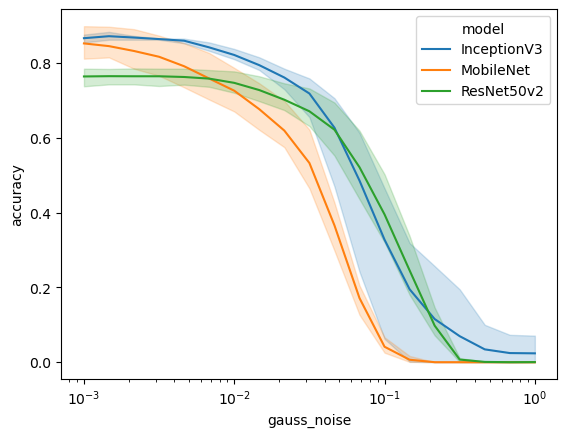

In [142]:
params = np.logspace(-3, 0, 19)
transforms_list = [A.GaussNoise(var_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_noise'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

#### Gamma

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 9.556099891662598, Accuracy: 0.07246376574039459
	Transform 2/19:
		Loss: 9.513021183013915, Accuracy: 0.07246376574039459
	Transform 3/19:
		Loss: 9.415106296539307, Accuracy: 0.07246376574039459
	Transform 4/19:
		Loss: 9.136446952819824, Accuracy: 0.07246376574039459
	Transform 5/19:
		Loss: 6.619854402542114, Accuracy: 0.239130437374115
	Transform 6/19:
		Loss: 3.8229230403900147, Accuracy: 0.4275362193584442
	Transform 7/19:
		Loss: 2.1977416038513184, Accuracy: 0.6376811861991882
	Transform 8/19:
		Loss: 1.2101887583732605, Accuracy: 0.7898550629615784
	Transform 9/19:
		Loss: 0.8068097233772278, Accuracy: 0.8333333134651184
	Transform 10/19:
		Loss: 0.5897654473781586, Accuracy: 0.8695651888847351
	Transform 11/19:
		Loss: 0.5364249467849731, Accuracy: 0.8695651888847351
	Transform 12/19:
		Loss: 0.7924931704998016, Accuracy: 0.7898550629615784
	Transform 13/19:
		Loss: 2.089662528038025, Accuracy: 0.594202

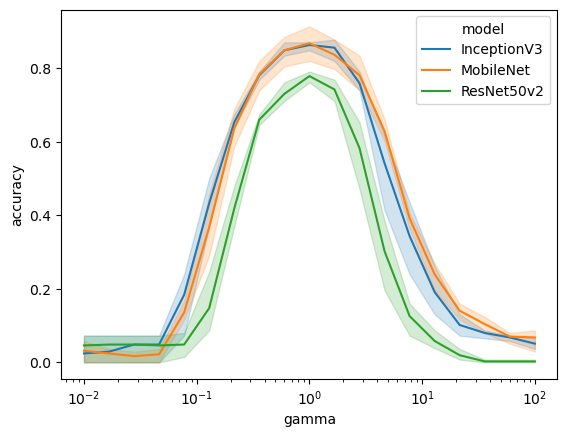

In [47]:
params = np.logspace(0,4,19)
transforms_list = [A.RandomGamma(gamma_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gamma'
}

df = test_transformed(selected, transforms, nature_ds, 10)

df[transforms['name']] /= 100 # Actual gamma parameter is 100 times smaller than the one passed to albumentations

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

#### Image compression

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:


c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 3.774340295791626, Accuracy: 0.47101449966430664
	Transform 2/19:
		Loss: 3.7575032711029053, Accuracy: 0.47826087474823
	Transform 3/19:
		Loss: 3.709665870666504, Accuracy: 0.49275362491607666
	Transform 4/19:
		Loss: 2.7711339712142946, Accuracy: 0.5652173757553101
	Transform 5/19:
		Loss: 2.6726780414581297, Accuracy: 0.6086956262588501
	Transform 6/19:
		Loss: 2.1426677942276, Accuracy: 0.6449275612831116
	Transform 7/19:
		Loss: 1.8413563013076781, Accuracy: 0.6666666865348816
	Transform 8/19:
		Loss: 1.6849759936332702, Accuracy: 0.7101449370384216
	Transform 9/19:
		Loss: 1.4956363201141358, Accuracy: 0.717391312122345
	Transform 10/19:
		Loss: 1.422515618801117, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.200235867500305, Accuracy: 0.7898550629615784
	Transform 12/19:
		Loss: 1.0577760457992553, Accuracy: 0.8188405632972717
	Transform 13/19:
		Loss: 0.9691285729408264, Accuracy: 0.8405796885490417
	Transform 14/19:
		Loss: 0.8451422154903412, Accuracy: 0.84

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 3.1105535507202147, Accuracy: 0.5289855003356934
	Transform 2/19:
		Loss: 3.116815209388733, Accuracy: 0.5289855003356934
	Transform 3/19:
		Loss: 3.160045313835144, Accuracy: 0.5507246255874634
	Transform 4/19:
		Loss: 2.4479806661605834, Accuracy: 0.6594203114509583
	Transform 5/19:
		Loss: 2.619631314277649, Accuracy: 0.6521739363670349
	Transform 6/19:
		Loss: 2.2365714073181153, Accuracy: 0.6884058117866516
	Transform 7/19:
		Loss: 1.8989810943603516, Accuracy: 0.7028985619544983
	Transform 8/19:
		Loss: 1.7103325963020324, Accuracy: 0.7318840622901917
	Transform 9/19:
		Loss: 1.5221626996994018, Accuracy: 0.7463768124580383
	Transform 10/19:
		Loss: 1.4830313086509705, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.298820185661316, Accuracy: 0.7681159377098083
	Transform 12/19:
		Loss: 1.1166515350341797, Accuracy: 0.782608687877655
	Transform 13/19:
		Loss: 1.019221580028534, Accuracy: 0.8115941882133484
	Transform 14/19:
		Loss: 0.9614830732345581, Accuracy: 0.

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 2.918421673774719, Accuracy: 0.5362318754196167
	Transform 2/19:
		Loss: 2.923040437698364, Accuracy: 0.5362318754196167
	Transform 3/19:
		Loss: 2.667151165008545, Accuracy: 0.5652173757553101
	Transform 4/19:
		Loss: 2.076854205131531, Accuracy: 0.6449275612831116
	Transform 5/19:
		Loss: 1.9430635929107667, Accuracy: 0.7246376872062683
	Transform 6/19:
		Loss: 1.6588927507400513, Accuracy: 0.7246376872062683
	Transform 7/19:
		Loss: 1.3209473848342896, Accuracy: 0.760869562625885
	Transform 8/19:
		Loss: 1.05894216299057, Accuracy: 0.7681159377098083
	Transform 9/19:
		Loss: 0.9297120690345764, Accuracy: 0.7753623127937317
	Transform 10/19:
		Loss: 0.93764888048172, Accuracy: 0.7898550629615784
	Transform 11/19:
		Loss: 0.9278871297836304, Accuracy: 0.804347813129425
	Transform 12/19:
		Loss: 0.7573856770992279, Accuracy: 0.8115941882133484
	Transform 13/19:
		Loss: 0.6368393659591675, Accuracy: 0.8333333134651184
	Transform 14/19:
		Loss: 0.6303203046321869, Accuracy: 0.840

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 6.533331346511841, Accuracy: 0.3188405930995941
	Transform 2/19:
		Loss: 6.49124116897583, Accuracy: 0.3333333432674408
	Transform 3/19:
		Loss: 6.111760807037354, Accuracy: 0.3695652186870575
	Transform 4/19:
		Loss: 4.711636781692505, Accuracy: 0.4202898442745209
	Transform 5/19:
		Loss: 3.412993597984314, Accuracy: 0.49275362491607666
	Transform 6/19:
		Loss: 2.6315871238708497, Accuracy: 0.5652173757553101
	Transform 7/19:
		Loss: 2.307703948020935, Accuracy: 0.6014492511749268
	Transform 8/19:
		Loss: 2.063913369178772, Accuracy: 0.6304348111152649
	Transform 9/19:
		Loss: 1.860591721534729, Accuracy: 0.6449275612831116
	Transform 10/19:
		Loss: 1.8589860916137695, Accuracy: 0.717391312122345
	Transform 11/19:
		Loss: 1.5980029582977295, Accuracy: 0.7463768124580383
	Transform 12/19:
		Loss: 1.480849289894104, Accuracy: 0.7681159377098083
	Transform 13/19:
		Loss: 1.3580866694450378, Accuracy: 0.7898550629615784
	Transform 14/19:
		Loss: 1.3146991848945617, Accuracy: 0.797

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 4.139761447906494, Accuracy: 0.4057970941066742
	Transform 2/19:
		Loss: 4.120168876647949, Accuracy: 0.4057970941066742
	Transform 3/19:
		Loss: 4.051485967636109, Accuracy: 0.43478259444236755
	Transform 4/19:
		Loss: 3.6228824138641356, Accuracy: 0.4637681245803833
	Transform 5/19:
		Loss: 3.1044931411743164, Accuracy: 0.5144927501678467
	Transform 6/19:
		Loss: 2.7687346935272217, Accuracy: 0.54347825050354
	Transform 7/19:
		Loss: 2.251527523994446, Accuracy: 0.6086956262588501
	Transform 8/19:
		Loss: 1.9579787254333496, Accuracy: 0.6594203114509583
	Transform 9/19:
		Loss: 1.7574317455291748, Accuracy: 0.6449275612831116
	Transform 10/19:
		Loss: 1.7780412435531616, Accuracy: 0.6666666865348816
	Transform 11/19:
		Loss: 1.3686243176460267, Accuracy: 0.739130437374115
	Transform 12/19:
		Loss: 1.122394609451294, Accuracy: 0.7318840622901917
	Transform 13/19:
		Loss: 0.9637794733047486, Accuracy: 0.760869562625885
	Transform 14/19:
		Loss: 0.9774491310119628, Accuracy: 0.7

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 6.283239459991455, Accuracy: 0.37681159377098083
	Transform 2/19:
		Loss: 6.33051381111145, Accuracy: 0.3695652186870575
	Transform 3/19:
		Loss: 5.686257457733154, Accuracy: 0.4202898442745209
	Transform 4/19:
		Loss: 3.848293161392212, Accuracy: 0.5289855003356934
	Transform 5/19:
		Loss: 2.816187310218811, Accuracy: 0.6304348111152649
	Transform 6/19:
		Loss: 2.3418842792510985, Accuracy: 0.695652186870575
	Transform 7/19:
		Loss: 1.6334243893623352, Accuracy: 0.739130437374115
	Transform 8/19:
		Loss: 1.5231862545013428, Accuracy: 0.760869562625885
	Transform 9/19:
		Loss: 1.2216484069824218, Accuracy: 0.8115941882133484
	Transform 10/19:
		Loss: 1.2078903436660766, Accuracy: 0.782608687877655
	Transform 11/19:
		Loss: 0.8073122382164002, Accuracy: 0.8405796885490417
	Transform 12/19:
		Loss: 0.8029170334339142, Accuracy: 0.8550724387168884
	Transform 13/19:
		Loss: 0.6603474318981171, Accuracy: 0.8695651888847351
	Transform 14/19:
		Loss: 0.6369265139102935, Accuracy: 0.85

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 7.654739475250244, Accuracy: 0.3840579688549042
	Transform 2/19:
		Loss: 7.631271171569824, Accuracy: 0.3840579688549042
	Transform 3/19:
		Loss: 6.864835023880005, Accuracy: 0.3913043439388275
	Transform 4/19:
		Loss: 4.8387682914733885, Accuracy: 0.4637681245803833
	Transform 5/19:
		Loss: 3.932289242744446, Accuracy: 0.5579710006713867
	Transform 6/19:
		Loss: 3.1781890392303467, Accuracy: 0.5942028760910034
	Transform 7/19:
		Loss: 2.6228404998779298, Accuracy: 0.6014492511749268
	Transform 8/19:
		Loss: 2.39215087890625, Accuracy: 0.6304348111152649
	Transform 9/19:
		Loss: 2.2732815742492676, Accuracy: 0.6594203114509583
	Transform 10/19:
		Loss: 2.303854727745056, Accuracy: 0.6739130616188049
	Transform 11/19:
		Loss: 2.220029377937317, Accuracy: 0.695652186870575
	Transform 12/19:
		Loss: 2.1447463750839235, Accuracy: 0.7246376872062683
	Transform 13/19:
		Loss: 2.0915114879608154, Accuracy: 0.717391312122345
	Transform 14/19:
		Loss: 1.9843405723571776, Accuracy: 0.739

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 5.266203451156616, Accuracy: 0.47826087474823
	Transform 2/19:
		Loss: 5.272489547729492, Accuracy: 0.47826087474823
	Transform 3/19:
		Loss: 4.944540548324585, Accuracy: 0.47101449966430664
	Transform 4/19:
		Loss: 3.7707875251770018, Accuracy: 0.5724637508392334
	Transform 5/19:
		Loss: 3.1474992990493775, Accuracy: 0.6811594367027283
	Transform 6/19:
		Loss: 2.8632341861724853, Accuracy: 0.695652186870575
	Transform 7/19:
		Loss: 2.633194327354431, Accuracy: 0.739130437374115
	Transform 8/19:
		Loss: 2.3909982204437257, Accuracy: 0.7536231875419617
	Transform 9/19:
		Loss: 2.3023279190063475, Accuracy: 0.739130437374115
	Transform 10/19:
		Loss: 2.39186315536499, Accuracy: 0.7536231875419617
	Transform 11/19:
		Loss: 2.2418468713760378, Accuracy: 0.782608687877655
	Transform 12/19:
		Loss: 2.213045525550842, Accuracy: 0.7753623127937317
	Transform 13/19:
		Loss: 2.2258508682250975, Accuracy: 0.7753623127937317
	Transform 14/19:
		Loss: 2.1583085298538207, Accuracy: 0.7753623

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 5.272618007659912, Accuracy: 0.5869565010070801
	Transform 2/19:
		Loss: 5.260151195526123, Accuracy: 0.5869565010070801
	Transform 3/19:
		Loss: 4.956619691848755, Accuracy: 0.5797101259231567
	Transform 4/19:
		Loss: 4.460313701629639, Accuracy: 0.6811594367027283
	Transform 5/19:
		Loss: 3.942967438697815, Accuracy: 0.6739130616188049
	Transform 6/19:
		Loss: 3.400480628013611, Accuracy: 0.695652186870575
	Transform 7/19:
		Loss: 3.401009678840637, Accuracy: 0.739130437374115
	Transform 8/19:
		Loss: 3.0505440711975096, Accuracy: 0.739130437374115
	Transform 9/19:
		Loss: 3.003540301322937, Accuracy: 0.7536231875419617
	Transform 10/19:
		Loss: 3.053498721122742, Accuracy: 0.7536231875419617
	Transform 11/19:
		Loss: 2.699475955963135, Accuracy: 0.7681159377098083
	Transform 12/19:
		Loss: 2.588721227645874, Accuracy: 0.7681159377098083
	Transform 13/19:
		Loss: 2.5355926513671876, Accuracy: 0.760869562625885
	Transform 14/19:
		Loss: 2.4841402769088745, Accuracy: 0.76086956

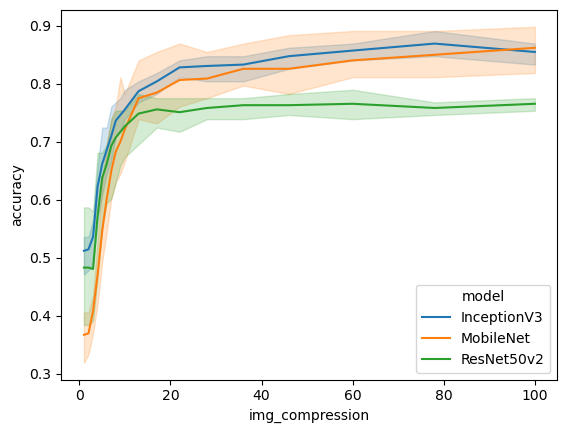

In [6]:
params = [1,2,3,4,5,6,7,8,9,10,13,17,22,28,36,46,60,78,100]
transforms_list = [A.ImageCompression(quality_lower=i, quality_upper=i, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'img_compression'
}

df = test_transformed(selected, transforms, ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

#### Gaussian blur

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.5897654354572296, Accuracy: 0.8695651888847351
	Transform 2/19:
		Loss: 0.6692057847976685, Accuracy: 0.8550724387168884
	Transform 3/19:
		Loss: 0.7896425008773804, Accuracy: 0.8405796885490417
	Transform 4/19:
		Loss: 1.0494293093681335, Accuracy: 0.8188405632972717
	Transform 5/19:
		Loss: 1.2758109807968139, Accuracy: 0.782608687877655
	Transform 6/19:
		Loss: 1.4962961554527283, Accuracy: 0.739130437374115
	Transform 7/19:
		Loss: 1.8432701110839844, Accuracy: 0.6739130616188049
	Transform 8/19:
		Loss: 2.4035842418670654, Accuracy: 0.5942028760910034
	Transform 9/19:
		Loss: 3.0523616790771486, Accuracy: 0.52173912525177
	Transform 10/19:
		Loss: 3.72802894115448, Accuracy: 0.47101449966430664
	Transform 11/19:
		Loss: 4.479701519012451, Accuracy: 0.3333333432674408
	Transform 12/19:
		Loss: 5.346041011810303, Accuracy: 0.2028985470533371
	Transform 13/19:
		Loss: 6.283002185821533, Accuracy: 0.08695652335

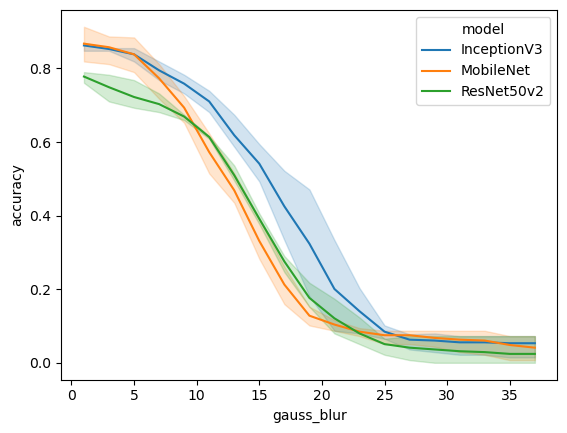

In [174]:
params = np.arange(1, 39, 2)
transforms_list = [A.GaussianBlur(blur_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_blur'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

#### Motion blur

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.6211290478706359, Accuracy: 0.8615941882133484
	Transform 2/19:
		Loss: 0.801071721315384, Accuracy: 0.8413043260574341
	Transform 3/19:
		Loss: 1.3576412916183471, Accuracy: 0.7746376752853393
	Transform 4/19:
		Loss: 2.238227701187134, Accuracy: 0.6449275493621827
	Transform 5/19:
		Loss: 3.1095695972442625, Accuracy: 0.556521725654602
	Transform 6/19:
		Loss: 4.2695060014724735, Accuracy: 0.4420289874076843
	Transform 7/19:
		Loss: 5.17979097366333, Accuracy: 0.36521739363670347
	Transform 8/19:
		Loss: 5.868490934371948, Accuracy: 0.31739130318164827
	Transform 9/19:
		Loss: 6.447264194488525, Accuracy: 0.28695652186870574
	Transform 10/19:
		Loss: 6.982268953323365, Accuracy: 0.24347825944423676
	Transform 11/19:
		Loss: 7.4160669326782225, Accuracy: 0.21666666567325593
	Transform 12/19:
		Loss: 7.9551044464111325, Accuracy: 0.18260869681835173
	Transform 13/19:
		Loss: 8.04686393737793, Accuracy: 0.1782608

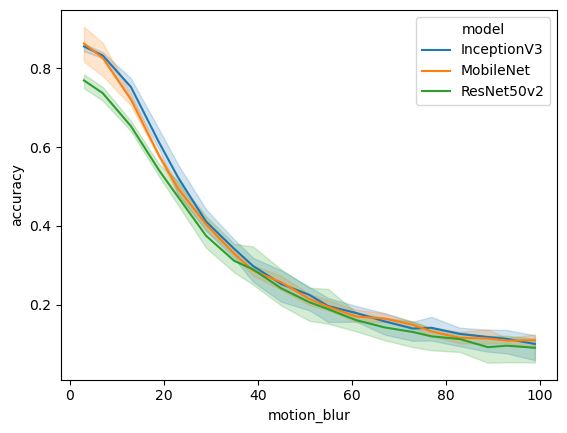

In [182]:
params = np.array(list(map(lambda x: x if x%2==1 else x-1, np.linspace(3,100,19).astype(int))))

transforms_list = [A.MotionBlur(blur_limit=(i, i), allow_shifted=False, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'motion_blur'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

#### Downscale

In [19]:
params = np.logspace(-2,0,19,endpoint=False)

transforms_list = [A.Downscale(scale_min=i, scale_max=i, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'downscale'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:


ValueError: in user code:

    File "d:\Master thesis\MasterThesis-1\tf_utils.py", line 306, in inner  *
        label.set_shape([])

    ValueError: Shapes must be equal rank, but are 1 and 0


#### Rotation

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.5897653043270111, Accuracy: 0.8695652484893799
	Transform 2/19:
		Loss: 0.698939198255539, Accuracy: 0.8188406229019165
	Transform 3/19:
		Loss: 0.6024623274803161, Accuracy: 0.8623188734054565
	Transform 4/19:
		Loss: 0.5366772770881653, Accuracy: 0.8695652484893799
	Transform 5/19:
		Loss: 0.5502060532569886, Accuracy: 0.8840579986572266
	Transform 6/19:
		Loss: 0.8455205678939819, Accuracy: 0.8333333730697632
	Transform 7/19:
		Loss: 1.044107449054718, Accuracy: 0.7101449370384216
	Transform 8/19:
		Loss: 1.2680810332298278, Accuracy: 0.6739130616188049
	Transform 9/19:
		Loss: 1.303928303718567, Accuracy: 0.6811594367027283
	Transform 10/19:
		Loss: 1.29655020236969, Accuracy: 0.6739130616188049
	Transform 11/19:
		Loss: 1.5275967121124268, Accuracy: 0.695652186870575
	Transform 12/19:
		Loss: 1.7082676768302918, Accuracy: 0.6594203114509583
	Transform 13/19:
		Loss: 1.5267395615577697, Accuracy: 0.695652186

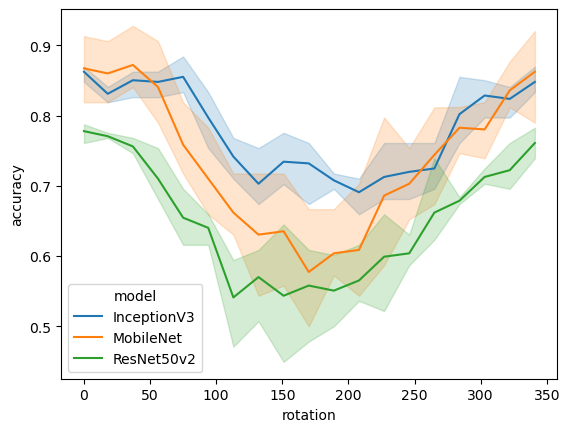

In [7]:
params = np.linspace(0, 360, 19, endpoint=False, dtype=int)
from cv2 import BORDER_REPLICATE
transforms_list = [A.Rotate(limit=(i,i), border_mode=BORDER_REPLICATE, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'rotation'
}

df = test_transformed(selected, transforms, ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv(f"image quality results/{transforms['name']}_aug{AUG}.csv")

# Augmentation

### Setting main parameters and seeds

In [2]:
# Parameters
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 2603
FPATH = 'D:/Master thesis/saved_models'
AUGMENTAION_PROPORTION = 1.0

tf.random.set_seed(SEED)
np.random.seed(SEED)

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

### Loading datasets

In [3]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
kaggle_ds = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=None
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = kaggle_ds.class_names
no_classes = len(class_names)
no_images = len(kaggle_ds)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(kaggle_ds, train_part, valid_part, test_part, seed=SEED)
print(f'Images in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
kaggle_ds = kaggle_ds.map(tf_utils.normalize).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(tf_utils.normalize).batch(BATCH_SIZE)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Images in subsets:
Train: 7023
Validation: 1504
Test: 1506


### Preparing augmentations

- Brightness limits: (-0.6, 0.6) or (-0.6, -0.3)+(0.3, 0.6) -> indexes (3, 6)+(12, 15)
- Contrast limits: (-0.8, -0.4)+(0.4, 0.8) -> indexes (1, 5)+(13, 17)
- Gamma correction: (,)-> indexes (5, 8)+(10, 13)
- Gaussian noise: (1e-3, 5e-2) -> indexes (0, 10)
- Gaussian blur: (1, 13) -> indexes (0, 6)
- Motion blur: (,) -> indexes (1, 4)
- Image compression: (1, 19) -> indexes (0, 11)
- Downscaling: (,) -> indexes (12, 16)
- Rotation: (75, 282) -> indexes (4, 15)

In [4]:
brightness_params = np.linspace(-0.9, 0.9, 19)
contrast_params = np.linspace(-0.9, 0.9, 19)
gamma_params = np.logspace(0, 4, 19)
gauss_noise_params = np.logspace(-3, 0, 19)
gauss_blur_params = np.arange(1, 39, 2)
motion_blur_params = np.array(list(map(lambda x: x if x % 2 == 1 else x - 1, np.linspace(3, 100, 19).astype(int))))
image_compression_params = [1,2,3,4,5,6,7,8,9,10,13,17,22,28,36,46,60,78,100]
downscale_params = np.logspace(-2, 0, 19, endpoint=False)
rotation_params = np.linspace(0, 360, 19, endpoint=False, dtype=int)

from cv2 import BORDER_REPLICATE

transforms = [
    A.RandomBrightnessContrast(brightness_limit=(brightness_params[3], brightness_params[6]), contrast_limit=0),
    A.RandomBrightnessContrast(brightness_limit=(brightness_params[12], brightness_params[15]), contrast_limit=0),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(contrast_params[1], contrast_params[5])),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(contrast_params[13], contrast_params[17])),
    A.RandomGamma(gamma_limit=(gamma_params[5], gamma_params[8])),
    A.RandomGamma(gamma_limit=(gamma_params[10], gamma_params[13])),
    A.GaussNoise(var_limit=(gauss_noise_params[0], gauss_noise_params[10])),
    A.GaussianBlur(blur_limit=(gauss_blur_params[0], gauss_blur_params[6])),
    A.MotionBlur(blur_limit=(motion_blur_params[1], motion_blur_params[4])),
    A.ImageCompression(quality_lower=image_compression_params[0], quality_upper=image_compression_params[11]),
    A.Downscale(scale_min=downscale_params[12], scale_max=downscale_params[16]),
    A.Rotate(limit=(rotation_params[4], rotation_params[15]), border_mode=BORDER_REPLICATE)
]

augmentation = A.OneOf(transforms, AUGMENTAION_PROPORTION)

c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


### Augmenting dataset

In [5]:
train_ds = train_ds\
    .map(tf_utils.prepare_mapping(augmentation))\
    .map(tf_utils.set_shapes())\
    .batch(BATCH_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

### Importing the model

#### Inception

In [6]:
# Constructing a model
name = 'InceptionV3'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dropout(rate=0.4, seed=SEED))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

#### MobileNet

In [6]:
# Constructing a model
name = 'MobileNet'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Compiling the model and fitting

In [7]:
# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 75)                76875     
                                                                 
Total params: 4,355,339
Trainable params: 4,333,451
Non-trainable params: 21,888
_________________________________________________________________


In [8]:
training_date = date.today()
model_dir_name = f'{model.name}_aug{AUGMENTAION_PROPORTION * 100:.0f}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name)
model_dir_name += str(ctr)

print(model_dir_name)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model',
        monitor='val_accuracy',
        save_best_only=True
    )
]

t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds),
    callbacks=callbacks
)

training_time = time() - t0

MobileNet_aug100_(2023-05-20)_0
Epoch 1/100


c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


220/220 [==============================] - ETA: 0s - loss: 1.5308 - accuracy: 0.6043

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 160s 510ms/step - loss: 1.5308 - accuracy: 0.6043 - val_loss: 1.9193 - val_accuracy: 0.5293
Epoch 2/100
220/220 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.8410

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 97s 433ms/step - loss: 0.5288 - accuracy: 0.8410 - val_loss: 1.2473 - val_accuracy: 0.6842
Epoch 3/100
220/220 [==============================] - 85s 376ms/step - loss: 0.3149 - accuracy: 0.9009 - val_loss: 1.3584 - val_accuracy: 0.6529
Epoch 4/100
220/220 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.9055

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 97s 431ms/step - loss: 0.3073 - accuracy: 0.9055 - val_loss: 1.1684 - val_accuracy: 0.6935
Epoch 5/100
220/220 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9329

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 96s 426ms/step - loss: 0.2144 - accuracy: 0.9329 - val_loss: 0.8850 - val_accuracy: 0.7912
Epoch 6/100
220/220 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9334

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 95s 420ms/step - loss: 0.2002 - accuracy: 0.9334 - val_loss: 0.8128 - val_accuracy: 0.8098
Epoch 7/100
220/220 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9513

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 95s 421ms/step - loss: 0.1584 - accuracy: 0.9513 - val_loss: 0.4790 - val_accuracy: 0.8916
Epoch 8/100
220/220 [==============================] - 83s 368ms/step - loss: 0.1526 - accuracy: 0.9519 - val_loss: 0.5367 - val_accuracy: 0.8710
Epoch 9/100
220/220 [==============================] - 83s 367ms/step - loss: 0.1555 - accuracy: 0.9522 - val_loss: 0.9774 - val_accuracy: 0.7972
Epoch 10/100
220/220 [==============================] - 83s 369ms/step - loss: 0.1390 - accuracy: 0.9560 - val_loss: 0.7456 - val_accuracy: 0.8504
Epoch 11/100
220/220 [==============================] - 84s 369ms/step - loss: 0.1238 - accuracy: 0.9618 - val_loss: 0.5761 - val_accuracy: 0.8770
Epoch 12/100
220/220 [==============================] - 84s 374ms/step - loss: 0.0925 - accuracy: 0.9710 - val_loss: 0.6538 - val_accuracy: 0.8677
Epoch 13/100
220/220 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9664

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 97s 431ms/step - loss: 0.1123 - accuracy: 0.9664 - val_loss: 0.5356 - val_accuracy: 0.8969
Epoch 14/100
220/220 [==============================] - 84s 372ms/step - loss: 0.0878 - accuracy: 0.9729 - val_loss: 0.9980 - val_accuracy: 0.8371
Epoch 15/100
220/220 [==============================] - 84s 374ms/step - loss: 0.1255 - accuracy: 0.9623 - val_loss: 0.9458 - val_accuracy: 0.7959
Epoch 16/100
220/220 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9708

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 96s 428ms/step - loss: 0.1059 - accuracy: 0.9708 - val_loss: 0.4798 - val_accuracy: 0.9043
Epoch 17/100
220/220 [==============================] - 84s 374ms/step - loss: 0.0854 - accuracy: 0.9754 - val_loss: 1.3702 - val_accuracy: 0.7706
Epoch 18/100
220/220 [==============================] - 84s 373ms/step - loss: 0.1254 - accuracy: 0.9638 - val_loss: 0.8636 - val_accuracy: 0.8531
Epoch 19/100
220/220 [==============================] - 84s 372ms/step - loss: 0.0850 - accuracy: 0.9766 - val_loss: 0.5977 - val_accuracy: 0.8910
Epoch 20/100
220/220 [==============================] - 83s 368ms/step - loss: 0.1004 - accuracy: 0.9704 - val_loss: 0.7902 - val_accuracy: 0.8570
Epoch 21/100
220/220 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9816

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 95s 421ms/step - loss: 0.0652 - accuracy: 0.9816 - val_loss: 0.4887 - val_accuracy: 0.9149
Epoch 22/100
220/220 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.9870

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 95s 423ms/step - loss: 0.0410 - accuracy: 0.9870 - val_loss: 0.4001 - val_accuracy: 0.9355
Epoch 23/100
220/220 [==============================] - 83s 368ms/step - loss: 0.0335 - accuracy: 0.9903 - val_loss: 0.4038 - val_accuracy: 0.9335
Epoch 24/100
220/220 [==============================] - 83s 367ms/step - loss: 0.0679 - accuracy: 0.9812 - val_loss: 0.9770 - val_accuracy: 0.8564
Epoch 25/100
220/220 [==============================] - 83s 369ms/step - loss: 0.1674 - accuracy: 0.9519 - val_loss: 1.0265 - val_accuracy: 0.8404
Epoch 26/100
220/220 [==============================] - 84s 371ms/step - loss: 0.0993 - accuracy: 0.9671 - val_loss: 0.6363 - val_accuracy: 0.8850
Epoch 27/100
220/220 [==============================] - 83s 369ms/step - loss: 0.0999 - accuracy: 0.9741 - val_loss: 0.4429 - val_accuracy: 0.9176
Epoch 28/100
220/220 [==============================] - 84s 373ms/step - loss: 0.0625 - accuracy: 0.9813 - val_loss: 0.4951 - val_a

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 99s 440ms/step - loss: 0.0369 - accuracy: 0.9879 - val_loss: 0.4109 - val_accuracy: 0.9368
Epoch 30/100
220/220 [==============================] - 85s 373ms/step - loss: 0.0524 - accuracy: 0.9852 - val_loss: 0.5734 - val_accuracy: 0.9009
Epoch 31/100
220/220 [==============================] - 83s 368ms/step - loss: 0.0812 - accuracy: 0.9785 - val_loss: 0.4631 - val_accuracy: 0.9249
Epoch 32/100
220/220 [==============================] - 83s 367ms/step - loss: 0.0515 - accuracy: 0.9839 - val_loss: 0.4745 - val_accuracy: 0.9269
Epoch 33/100
220/220 [==============================] - 83s 368ms/step - loss: 0.0383 - accuracy: 0.9888 - val_loss: 0.4291 - val_accuracy: 0.9309
Epoch 34/100
220/220 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9907

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 97s 434ms/step - loss: 0.0333 - accuracy: 0.9907 - val_loss: 0.4185 - val_accuracy: 0.9382
Epoch 35/100
220/220 [==============================] - 83s 368ms/step - loss: 0.0533 - accuracy: 0.9839 - val_loss: 0.6834 - val_accuracy: 0.8870
Epoch 36/100
220/220 [==============================] - 83s 368ms/step - loss: 0.0889 - accuracy: 0.9739 - val_loss: 0.5927 - val_accuracy: 0.9029
Epoch 37/100
220/220 [==============================] - 84s 370ms/step - loss: 0.0747 - accuracy: 0.9794 - val_loss: 0.5643 - val_accuracy: 0.9109
Epoch 38/100
220/220 [==============================] - 83s 368ms/step - loss: 0.0444 - accuracy: 0.9875 - val_loss: 0.5574 - val_accuracy: 0.9129
Epoch 39/100
220/220 [==============================] - 83s 367ms/step - loss: 0.0529 - accuracy: 0.9848 - val_loss: 0.5322 - val_accuracy: 0.9189
Epoch 40/100
220/220 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9838

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 95s 421ms/step - loss: 0.0597 - accuracy: 0.9838 - val_loss: 0.3695 - val_accuracy: 0.9402
Epoch 41/100
220/220 [==============================] - 84s 374ms/step - loss: 0.0564 - accuracy: 0.9841 - val_loss: 0.4744 - val_accuracy: 0.9309
Epoch 42/100
220/220 [==============================] - 83s 369ms/step - loss: 0.0733 - accuracy: 0.9795 - val_loss: 0.5250 - val_accuracy: 0.9116
Epoch 43/100
220/220 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9878

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 96s 426ms/step - loss: 0.0390 - accuracy: 0.9878 - val_loss: 0.4855 - val_accuracy: 0.9408
Epoch 44/100
220/220 [==============================] - 84s 372ms/step - loss: 0.0532 - accuracy: 0.9859 - val_loss: 0.4002 - val_accuracy: 0.9342
Epoch 45/100
220/220 [==============================] - 84s 370ms/step - loss: 0.0574 - accuracy: 0.9842 - val_loss: 0.6212 - val_accuracy: 0.9023
Epoch 46/100
220/220 [==============================] - 85s 377ms/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 0.4515 - val_accuracy: 0.9309
Epoch 47/100
220/220 [==============================] - 86s 380ms/step - loss: 0.0368 - accuracy: 0.9896 - val_loss: 0.4373 - val_accuracy: 0.9255
Epoch 48/100
220/220 [==============================] - 85s 378ms/step - loss: 0.0497 - accuracy: 0.9878 - val_loss: 0.5705 - val_accuracy: 0.9142
Epoch 49/100
220/220 [==============================] - 86s 378ms/step - loss: 0.0534 - accuracy: 0.9845 - val_loss: 0.4238 - val_a

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 98s 434ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.3931 - val_accuracy: 0.9495
Epoch 52/100
220/220 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9976

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 97s 429ms/step - loss: 0.0100 - accuracy: 0.9976 - val_loss: 0.3312 - val_accuracy: 0.9561
Epoch 53/100
220/220 [==============================] - 83s 367ms/step - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.4271 - val_accuracy: 0.9495
Epoch 54/100
220/220 [==============================] - 84s 370ms/step - loss: 0.0993 - accuracy: 0.9741 - val_loss: 0.7225 - val_accuracy: 0.8790
Epoch 55/100
220/220 [==============================] - 85s 377ms/step - loss: 0.0772 - accuracy: 0.9778 - val_loss: 0.5381 - val_accuracy: 0.9089
Epoch 56/100
220/220 [==============================] - 85s 375ms/step - loss: 0.0414 - accuracy: 0.9886 - val_loss: 0.4038 - val_accuracy: 0.9375
Epoch 57/100
220/220 [==============================] - 83s 367ms/step - loss: 0.0219 - accuracy: 0.9950 - val_loss: 0.4153 - val_accuracy: 0.9495
Epoch 58/100
220/220 [==============================] - 84s 372ms/step - loss: 0.0536 - accuracy: 0.9865 - val_loss: 0.3855 - val_a

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 93s 413ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.3904 - val_accuracy: 0.9628
Epoch 74/100
220/220 [==============================] - 81s 361ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.4541 - val_accuracy: 0.9535
Epoch 75/100
220/220 [==============================] - 82s 362ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.6379 - val_accuracy: 0.9249
Epoch 76/100
220/220 [==============================] - 82s 363ms/step - loss: 0.0872 - accuracy: 0.9785 - val_loss: 0.9775 - val_accuracy: 0.8577
Epoch 77/100
220/220 [==============================] - 82s 364ms/step - loss: 0.0657 - accuracy: 0.9801 - val_loss: 0.5891 - val_accuracy: 0.9309
Epoch 78/100
220/220 [==============================] - 85s 374ms/step - loss: 0.0388 - accuracy: 0.9896 - val_loss: 0.7685 - val_accuracy: 0.9109
Epoch 79/100
220/220 [==============================] - 84s 371ms/step - loss: 0.0460 - accuracy: 0.9893 - val_loss: 0.5080 - val_a

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 93s 415ms/step - loss: 1.2028e-05 - accuracy: 1.0000 - val_loss: 0.3679 - val_accuracy: 0.9634
Epoch 93/100
220/220 [==============================] - ETA: 0s - loss: 1.0585e-05 - accuracy: 1.0000

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 93s 413ms/step - loss: 1.0585e-05 - accuracy: 1.0000 - val_loss: 0.3689 - val_accuracy: 0.9641
Epoch 94/100
220/220 [==============================] - 82s 364ms/step - loss: 9.3383e-06 - accuracy: 1.0000 - val_loss: 0.3698 - val_accuracy: 0.9641
Epoch 95/100
220/220 [==============================] - 84s 372ms/step - loss: 8.2560e-06 - accuracy: 1.0000 - val_loss: 0.3708 - val_accuracy: 0.9641
Epoch 96/100
220/220 [==============================] - 85s 378ms/step - loss: 7.3141e-06 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 0.9641
Epoch 97/100
220/220 [==============================] - 87s 384ms/step - loss: 6.4887e-06 - accuracy: 1.0000 - val_loss: 0.3727 - val_accuracy: 0.9641
Epoch 98/100
220/220 [==============================] - 87s 388ms/step - loss: 5.7640e-06 - accuracy: 1.0000 - val_loss: 0.3737 - val_accuracy: 0.9641
Epoch 99/100
220/220 [==============================] - 96s 427ms/step - loss: 5.1251e-06 - accuracy: 1.000

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/MobileNet_aug100_(2023-05-20)_0\model\assets


220/220 [==============================] - 111s 494ms/step - loss: 4.5603e-06 - accuracy: 1.0000 - val_loss: 0.3757 - val_accuracy: 0.9648


In [13]:
training_time = 298 * 60 + 35.9
data=\
'''220/220 [==============================] - ETA: 0s - loss: 1.7781 - accuracy: 0.5402
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 258s 898ms/step - loss: 1.7781 - accuracy: 0.5402 - val_loss: 3.9171 - val_accuracy: 0.3032
Epoch 2/100
220/220 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.7905
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 158s 710ms/step - loss: 0.7238 - accuracy: 0.7905 - val_loss: 1.6547 - val_accuracy: 0.6044
Epoch 3/100
220/220 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8634
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 158s 712ms/step - loss: 0.4617 - accuracy: 0.8634 - val_loss: 0.6654 - val_accuracy: 0.8258
Epoch 4/100
220/220 [==============================] - 114s 507ms/step - loss: 0.3312 - accuracy: 0.9010 - val_loss: 1.3937 - val_accuracy: 0.6709
Epoch 5/100
220/220 [==============================] - 115s 516ms/step - loss: 0.2805 - accuracy: 0.9183 - val_loss: 0.7185 - val_accuracy: 0.8032
Epoch 6/100
220/220 [==============================] - 116s 517ms/step - loss: 0.2261 - accuracy: 0.9315 - val_loss: 1.3948 - val_accuracy: 0.7114
Epoch 7/100
220/220 [==============================] - 116s 518ms/step - loss: 0.1704 - accuracy: 0.9496 - val_loss: 0.6615 - val_accuracy: 0.8258
Epoch 8/100
220/220 [==============================] - 116s 515ms/step - loss: 0.1895 - accuracy: 0.9448 - val_loss: 1.7446 - val_accuracy: 0.6762
Epoch 9/100
220/220 [==============================] - 119s 531ms/step - loss: 0.1425 - accuracy: 0.9587 - val_loss: 1.0087 - val_accuracy: 0.7879
Epoch 10/100
220/220 [==============================] - 122s 543ms/step - loss: 0.1439 - accuracy: 0.9574 - val_loss: 0.9915 - val_accuracy: 0.7952
Epoch 11/100
220/220 [==============================] - 122s 544ms/step - loss: 0.1395 - accuracy: 0.9586 - val_loss: 0.9041 - val_accuracy: 0.8059
Epoch 12/100
220/220 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9509
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 148s 664ms/step - loss: 0.1770 - accuracy: 0.9509 - val_loss: 0.5181 - val_accuracy: 0.8890
Epoch 13/100
220/220 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9735
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 141s 635ms/step - loss: 0.0917 - accuracy: 0.9735 - val_loss: 0.4428 - val_accuracy: 0.8903
Epoch 14/100
220/220 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9816
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 152s 683ms/step - loss: 0.0673 - accuracy: 0.9816 - val_loss: 0.3012 - val_accuracy: 0.9309
Epoch 15/100
220/220 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9848
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 168s 756ms/step - loss: 0.0538 - accuracy: 0.9848 - val_loss: 0.3234 - val_accuracy: 0.9342
Epoch 16/100
220/220 [==============================] - 113s 505ms/step - loss: 0.0851 - accuracy: 0.9749 - val_loss: 0.4224 - val_accuracy: 0.8956
Epoch 17/100
220/220 [==============================] - 104s 463ms/step - loss: 0.1502 - accuracy: 0.9559 - val_loss: 1.7423 - val_accuracy: 0.6928
Epoch 18/100
220/220 [==============================] - 104s 464ms/step - loss: 0.1246 - accuracy: 0.9626 - val_loss: 1.6058 - val_accuracy: 0.7041
Epoch 19/100
220/220 [==============================] - 105s 467ms/step - loss: 0.0973 - accuracy: 0.9701 - val_loss: 0.4101 - val_accuracy: 0.9096
Epoch 20/100
220/220 [==============================] - 123s 548ms/step - loss: 0.0712 - accuracy: 0.9779 - val_loss: 0.3975 - val_accuracy: 0.9182
Epoch 21/100
220/220 [==============================] - 122s 543ms/step - loss: 0.0639 - accuracy: 0.9811 - val_loss: 1.1616 - val_accuracy: 0.7653
Epoch 22/100
220/220 [==============================] - 122s 544ms/step - loss: 0.1097 - accuracy: 0.9677 - val_loss: 0.8079 - val_accuracy: 0.8265
Epoch 23/100
220/220 [==============================] - 111s 493ms/step - loss: 0.0908 - accuracy: 0.9758 - val_loss: 0.4037 - val_accuracy: 0.9215
Epoch 24/100
220/220 [==============================] - 122s 546ms/step - loss: 0.0648 - accuracy: 0.9828 - val_loss: 0.5034 - val_accuracy: 0.8976
Epoch 25/100
220/220 [==============================] - 178s 800ms/step - loss: 0.0342 - accuracy: 0.9906 - val_loss: 0.1813 - val_accuracy: 0.9641
Epoch 26/100
220/220 [==============================] - 125s 557ms/step - loss: 0.0231 - accuracy: 0.9932 - val_loss: 0.2335 - val_accuracy: 0.9561
Epoch 27/100
220/220 [==============================] - 126s 560ms/step - loss: 0.0431 - accuracy: 0.9880 - val_loss: 0.6276 - val_accuracy: 0.8883
Epoch 28/100
220/220 [==============================] - 124s 552ms/step - loss: 0.0828 - accuracy: 0.9764 - val_loss: 0.9434 - val_accuracy: 0.8178
Epoch 29/100
220/220 [==============================] - 127s 564ms/step - loss: 0.0905 - accuracy: 0.9734 - val_loss: 0.4922 - val_accuracy: 0.8983
Epoch 30/100
220/220 [==============================] - 135s 604ms/step - loss: 0.1084 - accuracy: 0.9670 - val_loss: 0.7324 - val_accuracy: 0.8650
Epoch 31/100
220/220 [==============================] - 136s 607ms/step - loss: 0.0662 - accuracy: 0.9804 - val_loss: 0.3184 - val_accuracy: 0.9388
Epoch 32/100
220/220 [==============================] - 144s 644ms/step - loss: 0.0685 - accuracy: 0.9812 - val_loss: 0.4701 - val_accuracy: 0.9109
Epoch 33/100
220/220 [==============================] - 148s 662ms/step - loss: 0.0343 - accuracy: 0.9910 - val_loss: 0.2222 - val_accuracy: 0.9555
Epoch 34/100
220/220 [==============================] - 145s 650ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.2225 - val_accuracy: 0.9621
Epoch 35/100
220/220 [==============================] - 145s 652ms/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 0.3547 - val_accuracy: 0.9435
Epoch 36/100
220/220 [==============================] - 133s 597ms/step - loss: 0.0988 - accuracy: 0.9741 - val_loss: 0.8988 - val_accuracy: 0.8364
Epoch 37/100
220/220 [==============================] - 127s 568ms/step - loss: 0.0987 - accuracy: 0.9698 - val_loss: 0.6226 - val_accuracy: 0.8863
Epoch 38/100
220/220 [==============================] - 131s 587ms/step - loss: 0.0429 - accuracy: 0.9880 - val_loss: 0.4531 - val_accuracy: 0.9282
Epoch 39/100
220/220 [==============================] - 182s 816ms/step - loss: 0.0525 - accuracy: 0.9856 - val_loss: 0.2904 - val_accuracy: 0.9441
Epoch 40/100
220/220 [==============================] - 199s 895ms/step - loss: 0.0349 - accuracy: 0.9902 - val_loss: 0.2474 - val_accuracy: 0.9515
Epoch 41/100
220/220 [==============================] - 277s 1s/step - loss: 0.0309 - accuracy: 0.9907 - val_loss: 0.3309 - val_accuracy: 0.9295
Epoch 42/100
220/220 [==============================] - 383s 2s/step - loss: 0.0333 - accuracy: 0.9899 - val_loss: 0.2985 - val_accuracy: 0.9395
Epoch 43/100
220/220 [==============================] - 382s 2s/step - loss: 0.0402 - accuracy: 0.9880 - val_loss: 0.6577 - val_accuracy: 0.8823
Epoch 44/100
220/220 [==============================] - 383s 2s/step - loss: 0.0798 - accuracy: 0.9792 - val_loss: 1.3356 - val_accuracy: 0.7872
Epoch 45/100
220/220 [==============================] - 399s 2s/step - loss: 0.0497 - accuracy: 0.9860 - val_loss: 0.3260 - val_accuracy: 0.9488
Epoch 46/100
220/220 [==============================] - 375s 2s/step - loss: 0.0492 - accuracy: 0.9876 - val_loss: 0.4595 - val_accuracy: 0.9156
Epoch 47/100
220/220 [==============================] - 364s 2s/step - loss: 0.0247 - accuracy: 0.9910 - val_loss: 0.4255 - val_accuracy: 0.9109
Epoch 48/100
220/220 [==============================] - 371s 2s/step - loss: 0.0395 - accuracy: 0.9890 - val_loss: 0.3346 - val_accuracy: 0.9408
Epoch 49/100
220/220 [==============================] - 380s 2s/step - loss: 0.0313 - accuracy: 0.9922 - val_loss: 0.3198 - val_accuracy: 0.9495
Epoch 50/100
220/220 [==============================] - 381s 2s/step - loss: 0.0269 - accuracy: 0.9935 - val_loss: 0.2604 - val_accuracy: 0.9588
Epoch 51/100
220/220 [==============================] - 380s 2s/step - loss: 0.0366 - accuracy: 0.9902 - val_loss: 0.6166 - val_accuracy: 0.8850
Epoch 52/100
220/220 [==============================] - 368s 2s/step - loss: 0.0772 - accuracy: 0.9811 - val_loss: 0.5658 - val_accuracy: 0.8989
Epoch 53/100
220/220 [==============================] - 370s 2s/step - loss: 0.0437 - accuracy: 0.9872 - val_loss: 0.2852 - val_accuracy: 0.9382
Epoch 54/100
220/220 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9935
220/220 [==============================] - 405s 2s/step - loss: 0.0238 - accuracy: 0.9935 - val_loss: 0.1924 - val_accuracy: 0.9648
Epoch 55/100
220/220 [==============================] - 361s 2s/step - loss: 0.0141 - accuracy: 0.9969 - val_loss: 0.2892 - val_accuracy: 0.9395
Epoch 56/100
220/220 [==============================] - 364s 2s/step - loss: 0.0604 - accuracy: 0.9848 - val_loss: 0.4822 - val_accuracy: 0.8936
Epoch 57/100
220/220 [==============================] - 365s 2s/step - loss: 0.0650 - accuracy: 0.9796 - val_loss: 0.2692 - val_accuracy: 0.9574
Epoch 58/100
220/220 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9922
WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 94). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug20_(2023-05-11)_0\model\assets
220/220 [==============================] - 411s 2s/step - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.1831 - val_accuracy: 0.9694
Epoch 59/100
220/220 [==============================] - 349s 2s/step - loss: 0.0192 - accuracy: 0.9953 - val_loss: 0.2273 - val_accuracy: 0.9568
Epoch 60/100
220/220 [==============================] - 361s 2s/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.1817 - val_accuracy: 0.9714
Epoch 61/100
220/220 [==============================] - 311s 1s/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.2459 - val_accuracy: 0.9614
Epoch 62/100
220/220 [==============================] - 292s 1s/step - loss: 0.0366 - accuracy: 0.9896 - val_loss: 0.4289 - val_accuracy: 0.9202
Epoch 63/100
220/220 [==============================] - 287s 1s/step - loss: 0.0681 - accuracy: 0.9815 - val_loss: 0.4509 - val_accuracy: 0.9215
Epoch 64/100
220/220 [==============================] - 281s 1s/step - loss: 0.0278 - accuracy: 0.9913 - val_loss: 1.6775 - val_accuracy: 0.8025
Epoch 65/100
220/220 [==============================] - 278s 1s/step - loss: 0.0610 - accuracy: 0.9832 - val_loss: 0.3649 - val_accuracy: 0.9309
Epoch 66/100
220/220 [==============================] - 248s 1s/step - loss: 0.0516 - accuracy: 0.9870 - val_loss: 0.3856 - val_accuracy: 0.9328
Epoch 67/100
220/220 [==============================] - 252s 1s/step - loss: 0.0224 - accuracy: 0.9939 - val_loss: 0.2447 - val_accuracy: 0.9634
Epoch 68/100
220/220 [==============================] - 248s 1s/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.2237 - val_accuracy: 0.9674
Epoch 69/100
220/220 [==============================] - 233s 1s/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.2299 - val_accuracy: 0.9641
Epoch 70/100
220/220 [==============================] - 227s 1s/step - loss: 0.0203 - accuracy: 0.9952 - val_loss: 0.2055 - val_accuracy: 0.9628
Epoch 71/100
220/220 [==============================] - 227s 1s/step - loss: 0.0251 - accuracy: 0.9940 - val_loss: 0.2975 - val_accuracy: 0.9402
Epoch 72/100
220/220 [==============================] - 220s 994ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.2312 - val_accuracy: 0.9687
Epoch 73/100
220/220 [==============================] - 229s 1s/step - loss: 0.0314 - accuracy: 0.9910 - val_loss: 0.5846 - val_accuracy: 0.9016
Epoch 74/100
220/220 [==============================] - 229s 1s/step - loss: 0.0735 - accuracy: 0.9805 - val_loss: 0.3693 - val_accuracy: 0.9282
Epoch 75/100
220/220 [==============================] - 229s 1s/step - loss: 0.0197 - accuracy: 0.9944 - val_loss: 0.2862 - val_accuracy: 0.9594
Epoch 76/100
220/220 [==============================] - 227s 1s/step - loss: 0.0196 - accuracy: 0.9940 - val_loss: 0.3704 - val_accuracy: 0.9402
Epoch 77/100
220/220 [==============================] - 230s 1s/step - loss: 0.0156 - accuracy: 0.9957 - val_loss: 0.2558 - val_accuracy: 0.9528
Epoch 78/100
220/220 [==============================] - 226s 1s/step - loss: 0.0208 - accuracy: 0.9946 - val_loss: 0.2442 - val_accuracy: 0.9654
Epoch 79/100
220/220 [==============================] - 225s 1s/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.2601 - val_accuracy: 0.9541
Epoch 80/100
220/220 [==============================] - 231s 1s/step - loss: 0.0556 - accuracy: 0.9853 - val_loss: 3.3115 - val_accuracy: 0.6416
Epoch 81/100
100/220 [============>.................] - ETA: 1:59 - loss: 0.0892 - accuracy: 0.9794'''

x = data.split('\n')
x = [i.split(' ') for i in x if 'val' in i]
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
for line in x:
    history['loss'].append(float(line[7]))
    history['accuracy'].append(float(line[10]))
    history['val_loss'].append(float(line[13]))
    history['val_accuracy'].append(float(line[16]))

history

{'loss': [1.7781,
  0.7238,
  0.4617,
  0.3312,
  0.2805,
  0.2261,
  0.1704,
  0.1895,
  0.1425,
  0.1439,
  0.1395,
  0.177,
  0.0917,
  0.0673,
  0.0538,
  0.0851,
  0.1502,
  0.1246,
  0.0973,
  0.0712,
  0.0639,
  0.1097,
  0.0908,
  0.0648,
  0.0342,
  0.0231,
  0.0431,
  0.0828,
  0.0905,
  0.1084,
  0.0662,
  0.0685,
  0.0343,
  0.0157,
  0.0236,
  0.0988,
  0.0987,
  0.0429,
  0.0525,
  0.0349,
  0.0309,
  0.0333,
  0.0402,
  0.0798,
  0.0497,
  0.0492,
  0.0247,
  0.0395,
  0.0313,
  0.0269,
  0.0366,
  0.0772,
  0.0437,
  0.0238,
  0.0141,
  0.0604,
  0.065,
  0.0258,
  0.0192,
  0.0102,
  0.0102,
  0.0366,
  0.0681,
  0.0278,
  0.061,
  0.0516,
  0.0224,
  0.008,
  0.0081,
  0.0203,
  0.0251,
  0.0139,
  0.0314,
  0.0735,
  0.0197,
  0.0196,
  0.0156,
  0.0208,
  0.0099,
  0.0556],
 'accuracy': [0.5402,
  0.7905,
  0.8634,
  0.901,
  0.9183,
  0.9315,
  0.9496,
  0.9448,
  0.9587,
  0.9574,
  0.9586,
  0.9509,
  0.9735,
  0.9816,
  0.9848,
  0.9749,
  0.9559,
  0.9626,
  0.

### Evaluation and saving

In [9]:
model = tf.keras.models.load_model(f'{FPATH}/{model_dir_name}/model')
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
nature_ds = nature_ds.cache().prefetch(tf.data.AUTOTUNE)

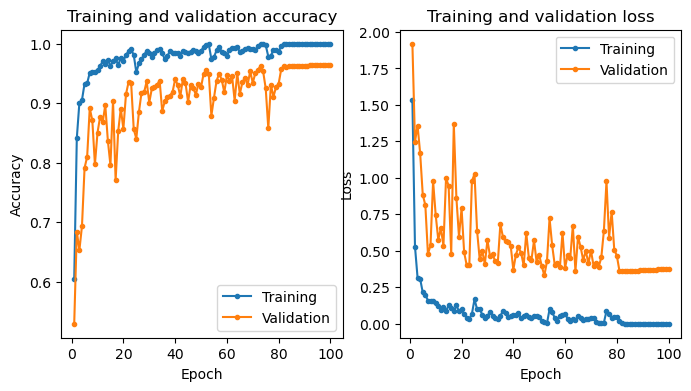

In [10]:
tf_utils.plot_history(history.history)

tf_utils.save_json(f'{FPATH}/{model_dir_name}/history.json', history.history)

In [11]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 58s 141ms/step - loss: 0.3342 - accuracy: 0.9602
Kaggle set evaluation: 
Test loss: 0.3342295289039612
Test accuracy: 0.960159420967102


1/1 [==============================] - 4s 4s/step


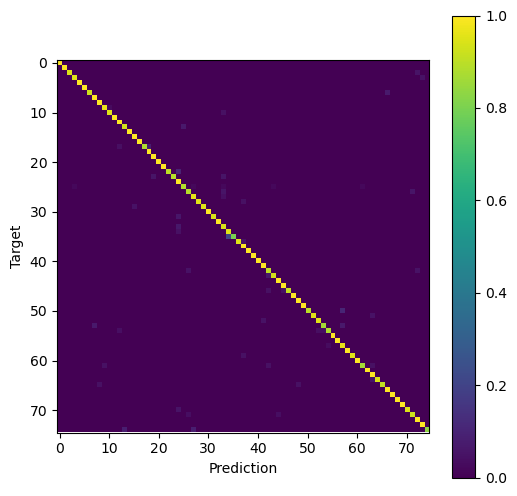

In [12]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m,figsize=(6,6))
plt.show()

In [13]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 8s 111ms/step - loss: 0.7545 - accuracy: 0.9058
Nature set evaluation: 
Test loss: 0.754503607749939
Test accuracy: 0.9057971239089966


1/1 [==============================] - 3s 3s/step


d:\Master thesis\MasterThesis-1\tf_utils.py:205: RuntimeWarning: invalid value encountered in divide
  conf_matrix[i, :] = conf_matrix[i, :] / conf_matrix[i, :].sum()


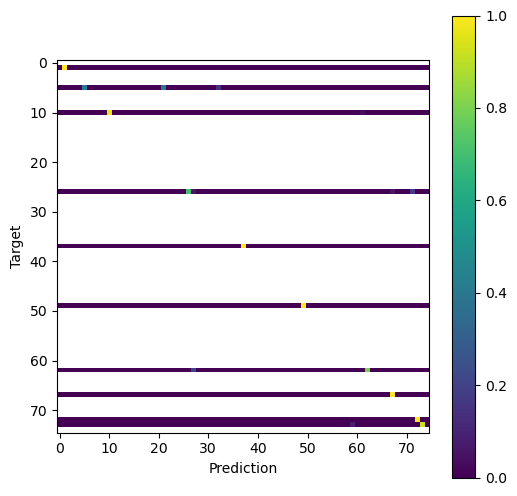

In [14]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m,figsize=(6,6))
plt.show()

In [15]:
# Evaluating inference time
t0 = time()
model.predict(kaggle_ds)
t1 = time()
inf_time = (t1 - t0) * 1000 / no_images
print(f'The average inference time: {inf_time:.2f}ms')

314/314 [==============================] - 55s 141ms/step
The average inference time: 5.47ms


In [16]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'batch_size': BATCH_SIZE,
    'seed': SEED,
    'epochs': EPOCHS,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'inference_time': inf_time,
    'comment': '',
    'test_confusion': m.tolist(),
    'nature_confusion': nature_m.tolist()
    }

tf_utils.save_json(f'{FPATH}/{model_dir_name}/info.json', info)

# Second test

In [8]:
# Listing available models
model_paths = list(pathlib.Path(FPATH).glob('*'))
for i, p in enumerate(model_paths):
    info = tf_utils.load_json(str(p) + '/info.json')
    print(i, p.name, info['test_accuracy'], info['nature_accuracy'])

selected = model_paths[9:12] + model_paths[28:31]
selected

0 InceptionV3_(2023-04-07)_0 0.974609375 0.8695652484893799
1 InceptionV3_(2023-04-08)_0 0.9791666865348816 0.8550724983215332
2 InceptionV3_(2023-04-08)_1 0.9798177480697632 0.8405797481536865
3 InceptionV3_aug100_(2023-05-10)_1 0.9594953656196594 0.7753623127937317
4 InceptionV3_aug100_(2023-05-13)_0 0.9641434550285339 0.8115942478179932
5 InceptionV3_aug100_(2023-05-14)_0 0.9628154039382935 0.8405797481536865
6 InceptionV3_aug20_(2023-05-11)_0 0.9661355018615723 0.8695652484893799
7 InceptionV3_aug20_(2023-05-12)_0 0.9687915444374084 0.8333333730697632
8 InceptionV3_aug20_(2023-05-15)_0 0.9694555401802063 0.8333333730697632
9 InceptionV3_aug40_(2023-05-11)_2 0.9774236679077148 0.8695652484893799
10 InceptionV3_aug40_(2023-05-12)_0 0.967463493347168 0.8405797481536865
11 InceptionV3_aug40_(2023-05-15)_0 0.9707835912704468 0.8985507488250732
12 InceptionV3_aug60_(2023-05-11)_0 0.9741036295890808 0.8695652484893799
13 InceptionV3_aug60_(2023-05-13)_0 0.9628154039382935 0.81159424781799

[WindowsPath('D:/Master thesis/saved_models/InceptionV3_aug40_(2023-05-11)_2'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_aug40_(2023-05-12)_0'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_aug40_(2023-05-15)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_aug40_(2023-05-16)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_aug40_(2023-05-18)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_aug40_(2023-05-19)_0')]

Testing InceptionV3_aug40_(2023-05-11)_2 in progress:
	Transform 1/19:
		Loss: 0.4883445829153061, Accuracy: 0.8862319111824035
	Transform 2/19:
		Loss: 0.4679418236017227, Accuracy: 0.8942029237747192
	Transform 3/19:
		Loss: 0.44451099038124087, Accuracy: 0.8920290112495423
	Transform 4/19:
		Loss: 0.4123893857002258, Accuracy: 0.900000023841858
	Transform 5/19:
		Loss: 0.3979188799858093, Accuracy: 0.8992753863334656
	Transform 6/19:
		Loss: 0.38183410465717316, Accuracy: 0.9036232113838196
	Transform 7/19:
		Loss: 0.38110837042331697, Accuracy: 0.9007246613502502
	Transform 8/19:
		Loss: 0.3954890787601471, Accuracy: 0.8927536487579346
	Transform 9/19:
		Loss: 0.415687620639801, Accuracy: 0.8949275612831116
	Transform 10/19:
		Loss: 0.5004290223121644, Accuracy: 0.8775362610816956
	Transform 11/19:
		Loss: 0.6087668180465698, Accuracy: 0.8471014857292175
	Transform 12/19:
		Loss: 0.8317834258079528, Accuracy: 0.7927536308765412
	Transform 13/19:
		Loss: 1.1717538714408875, Accuracy

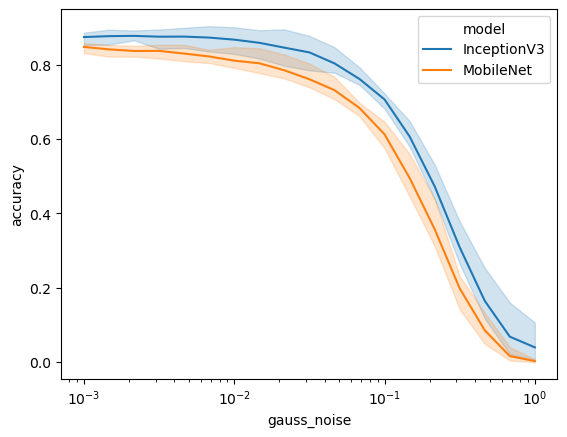

In [11]:
params = np.logspace(-3, 0, 19)
transforms_list = [A.GaussNoise(var_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_noise'
}

df = test_transformed(selected, transforms, ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'_aug40.csv')

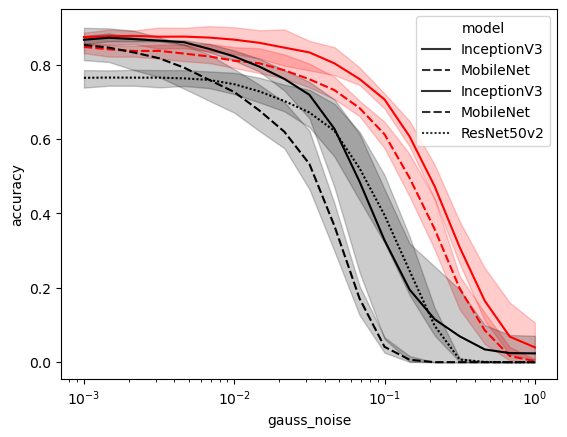

In [20]:
df2 = pd.read_csv('image quality results/gauss_noise.csv',index_col=0)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', style='model', color='red')
sns.lineplot(data=df2, x=transforms['name'], y='accuracy', style='model', color='black')
plt.xscale('log')
plt.show()


In [43]:
df['gauss_noise'] = df['gauss_noise'].apply(lambda x: round(x, 4))
g1 = df.groupby(['model','gauss_noise']).mean()
g1

C:\Users\Admin\AppData\Local\Temp\ipykernel_13840\1999233831.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g1 = df.groupby(['model','gauss_noise']).mean()


loss  accuracy
model       gauss_noise                    
InceptionV3 0.0010       0.627344  0.874396
            0.0015       0.624248  0.876812
            0.0022       0.624465  0.877536
            0.0032       0.609424  0.875362
            0.0046       0.616333  0.875604
            0.0068       0.615626  0.872947
            0.0100       0.627071  0.867391
            0.0147       0.646154  0.858937
            0.0215       0.692844  0.845894
            0.0316       0.772250  0.833092
            0.0464       0.874138  0.803623
            0.0681       1.091525  0.761594
            0.1000       1.410850  0.706522
            0.1468       1.923219  0.607005
            0.2154       2.768047  0.472947
            0.3162       3.947094  0.308937
            0.4642       5.154025  0.164976
            0.6813       6.194987  0.068599
            1.0000       6.896243  0.039855
MobileNet   0.0010       0.793825  0.847826
            0.0015       0.820275  0.841304
            0.0022       0.867236  0.836957
            0.0032       0.908789  0.837198
            0.0046       0.938537  0.829952
            0.0068       1.003466  0.822222
            0.0100       1.074752  0.810870
            0.0147       1.146194  0.803865
            0.0215       1.273460  0.785024
            0.0316       1.421231  0.760870
            0.0464       1.564844  0.731643
            0.0681       1.791776  0.683575
            0.1000       2.176381  0.612802
            0.1468       2.824318  0.495411
            0.2154       3.761099  0.357729
            0.3162       4.767833  0.198309
            0.4642       5.564020  0.085749
            0.6813       6.082195  0.016425
            1.0000       6.505049  0.002899

In [44]:
df2['gauss_noise'] = df2['gauss_noise'].apply(lambda x: round(x, 4))
g2 = df2[df2.model.isin(['InceptionV3','MobileNet'])].groupby(['model','gauss_noise']).mean()
g2

C:\Users\Admin\AppData\Local\Temp\ipykernel_13840\3165540739.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g2 = df2[df2.model.isin(['InceptionV3','MobileNet'])].groupby(['model','gauss_noise']).mean()


loss  accuracy
model       gauss_noise                     
InceptionV3 0.0010        0.562510  0.867150
            0.0015        0.561449  0.872464
            0.0022        0.570015  0.868841
            0.0032        0.585219  0.864734
            0.0046        0.620667  0.860386
            0.0068        0.686258  0.842512
            0.0100        0.807278  0.822222
            0.0147        0.971824  0.794928
            0.0215        1.230175  0.761836
            0.0316        1.652024  0.719082
            0.0464        2.653669  0.627536
            0.0681        4.757950  0.485990
            0.1000        8.106366  0.327778
            0.1468       12.182948  0.195169
            0.2154       16.142837  0.115459
            0.3162       19.246281  0.069565
            0.4642       21.637656  0.034300
            0.6813       23.412340  0.024396
            1.0000       24.545307  0.023671
MobileNet   0.0010        0.720500  0.853140
            0.0015        0.741317  0.845894
            0.0022        0.800606  0.832850
            0.0032        0.875184  0.817391
            0.0046        0.994316  0.792029
            0.0068        1.181644  0.759179
            0.0100        1.452733  0.726570
            0.0147        1.781537  0.677053
            0.0215        2.248217  0.619807
            0.0316        2.891615  0.533092
            0.0464        4.089463  0.366184
            0.0681        6.078504  0.171498
            0.1000        8.937732  0.041304
            0.1468       12.278912  0.006522
            0.2154       15.688334  0.000000
            0.3162       18.690871  0.000000
            0.4642       20.884045  0.000000
            0.6813       22.459734  0.000000
            1.0000       23.489397  0.000000

In [42]:
(g1 - g2)

loss  accuracy
model       gauss_noise                     
InceptionV3 0.0010        0.064835  0.007246
            0.0015        0.062800  0.004348
            0.0022        0.054450  0.008696
            0.0032        0.024205  0.010628
            0.0046       -0.004334  0.015217
            0.0068       -0.070631  0.030435
            0.0100       -0.180207  0.045169
            0.0147       -0.325670  0.064010
            0.0215       -0.537331  0.084058
            0.0316       -0.879774  0.114010
            0.0464       -1.779531  0.176087
            0.0681       -3.666426  0.275604
            0.1000       -6.695517  0.378744
            0.1468      -10.259728  0.411836
            0.2154      -13.374790  0.357488
            0.3162      -15.299187  0.239372
            0.4642      -16.483632  0.130676
            0.6813      -17.217354  0.044203
            1.0000      -17.649064  0.016184
MobileNet   0.0010        0.073325 -0.005314
            0.0015        0.078957 -0.004589
            0.0022        0.066629  0.004106
            0.0032        0.033605  0.019807
            0.0046       -0.055779  0.037923
            0.0068       -0.178178  0.063043
            0.0100       -0.377981  0.084300
            0.0147       -0.635344  0.126812
            0.0215       -0.974757  0.165217
            0.0316       -1.470384  0.227778
            0.0464       -2.524619  0.365459
            0.0681       -4.286727  0.512077
            0.1000       -6.761351  0.571498
            0.1468       -9.454594  0.488889
            0.2154      -11.927235  0.357729
            0.3162      -13.923038  0.198309
            0.4642      -15.320026  0.085749
            0.6813      -16.377539  0.016425
            1.0000      -16.984347  0.002899